-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# LLMs and Society

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Learn representation bias in training data 
1. Use Hugging Face to calculate toxicity score
1. Use SHAP to generate explanation on model output
1. Learn the latest state of research in model explanation: contrastive explanation

## Classroom Setup

In [0]:
%pip install disaggregators==0.1.2 https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.5.0/en_core_web_lg-3.5.0-py3-none-any.whl

Python interpreter will be restarted.
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached datasets-2.13.0-py3-none-any.whl (485 kB)
  Using cached sentencepiece-0.1.99-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached aiohttp-3.8.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached pyarrow-12.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.0 MB)
  Using cached multiprocess-0.70.14-py39-none-any.whl (132 kB)
  Using cached xxhash-3.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (212 kB)
  Using cached frozenlist-1.3.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (158 kB)
  Using cached yarl-1.9.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (269 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached multidict-6.0.4-cp39-cp39-manyli

In [0]:
%pip install evaluate

Python interpreter will be restarted.
  Using cached evaluate-0.4.0-py3-none-any.whl (81 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
Python interpreter will be restarted.


In [0]:
# %run ../Includes/Classroom-Setup

## Examining representation bias in Wikipedia biographies

[Disaggregators](https://github.com/huggingface/disaggregators) is a library developed by Hugging Face. As the name implies, it "dis-aggregates" data so that we can explore the data in more granular detail and evaluate data bias.

There are multiple disaggregation modules available: 
- age
- gender
- religion
- continent
- pronoun

We will be loading Wikipedia bios as our datasets to analyze later. We will be using the `pronoun` module since it takes the least amount of time to dis-aggregate. You are welcome to try out other modules in your own time. 

**DISCLAIMER**: 
- Warning: Some content may be triggering.
- The models developed or used in this course are for demonstration and learning purposes only. Models may occasionally output offensive, inaccurate, biased information, or harmful instructions.



**IMPORTANT**:
- For `gender` disaggregator to work, you need to download spacy's `en_core_web_lg` model. 
  - That's the model Hugging Face is using behind the scene! 
  - Hence, you can see the `.whl` file install in the `%pip install` command above. 
  - The model is directly download from [spaCy's GitHub](https://github.com/explosion/spacy-models/releases?q=en_core_web_lg).

In [0]:
from disaggregators import Disaggregator

disaggregator = Disaggregator("pronoun", column="target_text")
# disaggregator = Disaggregator("gender", column="target_text")
# disaggregator = Disaggregator("continent", column="target_text")
# disaggregator = Disaggregator("religion", column="target_text")
# disaggregator = Disaggregator("age", column="target_text")

We will use [Wikipedia biographies dataset](https://huggingface.co/datasets/wiki_bio), `wiki_bio`, readily available in the Hugging Face Datasets. From the dataset summary, the data contains the first paragraph of the biography and the tabular infobox. 

As you see, disaggreator works with Hugging Face datasets or any datasets where `.map` can be invoked. The `disaggregators` library attempts to group the wiki bio into `she_her`, `he_him`, and `they_them`.

Note: the cell below might take a couple minutes for the data to finish loading and for the disaggregator to categorize the data.

In [0]:
from datasets import load_dataset

wiki_data = load_dataset("wiki_bio", split="test")  # Note: We specify cache_dir to use pre-cached data.
ds = wiki_data.map(disaggregator)
pdf = ds.to_pandas()

Generating train split:   0%|          | 0/582659 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/72831 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/72831 [00:00<?, ? examples/s]

Dataset wiki_bio downloaded and prepared to /root/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da. Subsequent calls will reuse this data.


Map:   0%|          | 0/72831 [00:00<?, ? examples/s]

In [0]:
# Let's take a look at the dataframe
pdf

input_text 
 target_text 
 pronoun.she_her 
 pronoun.he_him 
 pronoun.they_them 
 
 
 
 
 0 
 {'table': {'column_header': ['finaldate', 'art... 
 leonard shenoff randle -lrb- born february 12 ... 
 False 
 True 
 False 
 
 
 1 
 {'table': {'column_header': ['article_title', ... 
 philippe adnot -lrb- born 25 august 1945 in rh... 
 False 
 True 
 False 
 
 
 2 
 {'table': {'column_header': ['nationality', 'a... 
 miroslav popov -lrb- born 14 june 1995 in dvůr... 
 False 
 True 
 False 
 
 
 3 
 {'table': {'column_header': ['youthyears', 'na... 
 john `` jack '' reynolds -lrb- 21 february 186... 
 False 
 True 
 False 
 
 
 4 
 {'table': {'column_header': ['article_title', ... 
 william ato ankrah , -lrb- born 7th july 1979 ... 
 False 
 True 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 72826 
 {'table': {'column_header': ['finaldate', 'art... 
 vernon scot thompson -lrb- born december 7 , 1... 
 False 
 True 
 False 
 
 
 72827 
 {'table': {'column_header': ['nationality', 'a... 
 shabtai shavit -lrb- ; born 17 july 1939 -rrb-... 
 False 
 True 
 False 
 
 
 72828 
 {'table': {'column_header': ['known_for', 'nat... 
 cesar andrade is a brazilian professional vert... 
 False 
 True 
 False 
 
 
 72829 
 {'table': {'column_header': ['article_title', ... 
 moulay hafid elalamy -lrb- born 1960 -rrb- is ... 
 False 
 True 
 False 
 
 
 72830 
 {'table': {'column_header': ['fullname', 'yout... 
 ashley james corker -lrb- born 18 september 19... 
 False 
 True 
 False 
 
 
 
 72831 rows × 5 columns

However, it doesn't do a very a good job at determining `they_them` as it seems to classify mentions of physical objects as `they_them` as well. For example, the 19th row has both pronoun categories, `they_them` and `he_him`, to be true. But looking at the data itself, we saw that the bio only used the the pronoun `he_him`: 

 >william ` bill ' rigby -lrb- 9 june 1921 - 1 june 2010 -rrb- was a former english footballer who played as a goalkeeper .\nhe was born in chester .\na product of the youth system at his hometown club of chester , rigby made his only peacetime first-team appearance for the club in their first post-war match in the football league in a 4 -- 4 draw at york city on 31 august 1946 .\nafter this he was not selected again , with goalkeeping duties being passed on to george scales and jim maclaren .\nearlier he had made appearances for the first-team during the war years , mainly during 1940 -- 41 and 1941 -- 42 while understudy to bill shortt

For this reason, the following analysis will ignore the column `pronoun.they_them`.

In [0]:
import json

print(pdf.iloc[[19], :].to_json(indent=4))

{
    "input_text":{
        "19":{
            "table":{
                "column_header":[
                    "fullname",
                    "youthyears",
                    "clubs",
                    "article_title",
                    "name",
                    "position",
                    "caps",
                    "birth_place",
                    "birth_date",
                    "goals",
                    "currentclub",
                    "years",
                    "youthclubs",
                    "death_date"
                ],
                "row_number":[
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1
                ],
                "content":[
                    "william rigby",
    

Let's do a simple aggregation to check the ratio of Wikipedian bios in terms of `he_him`

In [0]:
import numpy as np

she_array = np.where(pdf["pronoun.she_her"] == True)
print(f"she_her: {len(she_array[0])} rows")
he_array = np.where(pdf["pronoun.he_him"] == True)
print(f"he_him: {len(he_array[0])} rows")

she_her: 9545 rows
he_him: 44004 rows


The `he_him` pronoun represents `44004/ (9545+44004)`, which is approximately 82% of the data! It is not hard to imagine that models trained on predominantly male data would exhibit bias towards males.

Let's confirm that existing pre-trained models, like BERT, does exhibit bias. BERT is trained on both Wikipedia and [books that are adapted into movies](https://huggingface.co/datasets/bookcorpus).

In [0]:
from transformers import pipeline

unmasker = pipeline(
    "fill-mask",
    model="bert-base-uncased"
)  # Note: We specify cache_dir to use pre-cached models.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


To probe what BERT outputs, we will intentionally insert [MASK] token and ask BERT to generate words to replace that [MASK] token.

In [0]:
result = unmasker("This woman works as a [MASK].")
print([r["token_str"] for r in result])

result = unmasker("This man works as a [MASK].")
print([r["token_str"] for r in result])

['nurse', 'maid', 'teacher', 'waitress', 'prostitute']
['carpenter', 'lawyer', 'farmer', 'businessman', 'doctor']


## Inspect toxicity

Now that we have inspected data and model bias above, let's evaluate the toxicity of language model outputs. To do this, we leverage another [Hugging Face library called `evaluate`](https://huggingface.co/docs/evaluate/index).

The `evaluate` library can measure language models from different angles:
<br>
- Toxicity: how problematic the completion is, such as hate speech
  - It uses [Facebook's `roberta-hate-speech-dynabench-r4-target` model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) behind the scene to compute toxicity.
- [HONEST](https://huggingface.co/spaces/evaluate-measurement/honest): how hurtful the completion is 
  - The model was [published in 2021](https://aclanthology.org/2021.naacl-main.191.pdf)
  - It works very similarly as our `unmasker` example in the cell directly above. It also replaces certain words with [MASK] tokens and evaluates the hurtfulness based on what the language models output.
- Regard: whether the completion regards a certain group higher than the others 
  - You will play with this in the lab! So we will save this for later.

In [0]:
import evaluate

toxicity = evaluate.load("toxicity", module_type="measurement")

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


Any toxicity value over 0.5 is arbitrarily defined as "toxic". Here, we refrain from typing literal curse words to increase the toxicity values. However, you can see that the third phrase is noticeably more toxic than the other two!

In [0]:
candidates = [
    "their kid loves reading books",
    "she curses and makes fun of people",
    "he is a wimp and pathetic loser",
]
toxicity.compute(predictions=candidates)

Out[2]: {'toxicity': [0.00013759204011876136,
  0.021460160613059998,
  0.08053390681743622]}

## Model Interpretability with SHAP 

Another interesting topic within language model evaluation is whether we can interpret LM outputs. **SH**apley **A**dditive ex**P**lanations (**SHAP**) is a popular approach to explain the output of a machine learning model. It is agnostic to the type of machine learning model you pass in; this means that we can try using SHAP to explain our language model outputs! 

See the <a href="http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions" target="_blank">SHAP NeurIPS</a> paper for details, and Christoph Molnar's book chapter on <a href="https://christophm.github.io/interpretable-ml-book/shapley.html" target="_blank">Shapley Values</a>. 

Take the diagram below as an example. SHAP's goal is to explain the $10,000 difference in the apartment price. We see that if cats are not allowed in the same apartment building, the price of the apartment is lower than if it were to allow cats. 

<img src="https://files.training.databricks.com/images/shap_permutation.png" width=500>

Image is sourced from Molnar's book. Read SHAP [documentation here](https://shap.readthedocs.io/en/latest/text_examples.html).

In this section, we are going to first load a text generation model from Hugging Face, provide an input sentence, and ask the model to complete the rest of the sentence. Then, we will ask SHAP to generate explanation behind the sentence completion.

In [0]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import shap

tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)

model = AutoModelForCausalLM.from_pretrained("gpt2")

# Set model decoder to true
# GPT is a decoder-only model
model.config.is_decoder = True
# We set configurations for the output text generation
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0,  # to turn off randomness
    "top_k": 50,
    "no_repeat_ngram_size": 2,
}

Feel free to modify the input sentence below to play around later!

In [0]:
input_sentence = ["Sunny days are the best days to go to the beach. So"]

The `shap.Explainer` is how we can interface with SHAP. We need to pass in our `tokenizer` because that's the tokenizer we use to vectorize the text. When SHAP masks certain tokens to generate explanation, the tokenizer helps us to retain the same number of tokens by replacing the word with the [MASK] token.

In [0]:
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(input_sentence)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.


  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer: 2it [00:33, 33.24s/it]               


Now we can check the contribution of each input token towards the output token. "Red" means positive contribution whereas "blue" means negative indication. The color intensity indicates the strength of the contribution. 

From the documentation:

> The base value is what the model outputs when the entire input text is masked, while f_outputclass(inputs)
 is the output of the model for the full original input. The SHAP values explain in an additive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value

In [0]:
shap.plots.text(shap_values)

[0] 
 
 

 outputs 
 , 
 if 
 you 
 're 
 looking 
 for -2 -3 -4 -5 -1 0 1 -4.0494 -4.0494 base value -2.14119 -2.14119 f , (inputs) 3.871 So <rect x="6.977778181116823%" y="40" height="20" width="46.30233466602805%" onmouseover="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_13').style.textDecoration = 'underline';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_13').style.opacity = 1;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_13').style.opacity = 1;" onmouseout="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_13').style.textDecoration = 'none';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_13').style.opacity = 0;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_13').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> -0.368 Sun -0.365 best -0.2 go -0.194 beach -0.168 the -0.139 ny -0.137 days -0.123 the -0.099 are -0.077 . -0.048 to -0.031 to -0.014 days <rect x="53.28011284714488%" y="40" height="20" width="4.397644242752108%" onmouseover="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_0').style.textDecoration = 'underline';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_0').style.opacity = 1;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_0').style.opacity = 1;" onmouseout="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_0').style.textDecoration = 'none';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_0').style.opacity = 0;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_0').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="57.677757089896986%" y="40" height="20" width="4.361855675103747%" onmouseover="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_5').style.textDecoration = 'underline';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_5').style.opacity = 1;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_5').style.opacity = 1;" onmouseout="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_5').style.textDecoration = 'none';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_5').style.opacity = 0;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_5').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="62.03961276500073%" y="40" height="20" width="2.3890431764999036%" onmouseover="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_8').style.textDecoration = 'underline';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_8').style.opacity = 1;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_8').style.opacity = 1;" onmouseout="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_8').style.textDecoration = 'none';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_8').style.opacity = 0;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_8').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="64.42865594150064%" y="40" height="20" width="2.3190099401527817%" onmouseover="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_11').style.textDecoration = 'underline';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_11').style.opacity = 1;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_11').style.opacity = 1;" onmouseout="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_11').style.textDecoration = 'none';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_11').style.opacity = 0;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_11').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="66.74766588165342%" y="40" height="20" width="2.0076885321708033%" onmouseover="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_10').style.textDecoration = 'underline';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_10').style.opacity = 1;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_10').style.opacity = 1;" onmouseout="document.getElementById('_tp_mvvbsnpzrlfvwensylsc_ind_10').style.textDecoration = 'none';document.getElementById('_fs_mvvbsnpzrlfvwensylsc_ind_10').style.opacity = 0;document.getElementById('_fb_mvvbsnpzrlfvwensylsc_ind_10').style.opacity = 0;" style="fill:rgb(0

The plot below shows which input tokens contributes most towards the output token `looking`.

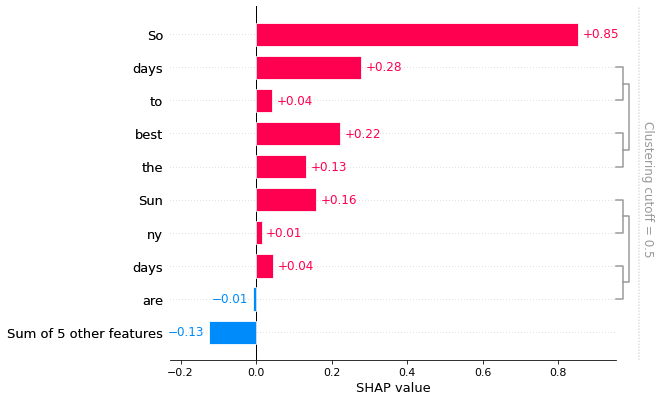

In [0]:
shap.plots.bar(shap_values[0, :, "looking"])

In [0]:
input_sentence2 = ["I know many people who prefer beaches to the mountains"]
shap_values2 = explainer(input_sentence2)
shap.plots.text(shap_values2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.


  0%|          | 0/90 [00:00<?, ?it/s]

[0] 
 
 

 outputs 
 , 
 but 
 I 
 'm 
 not 
 one 
 of 
 them 
 . 
 I -2 -3 -4 -5 -6 -1 0 1 -4.0494 -4.0494 base value -0.997367 -0.997367 f , (inputs) 4.814 mountains 0.171 to 0.117 many 0.102 prefer <rect x="12.473398552901923%" y="40" height="20" width="53.3663399249818%" onmouseover="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_9').style.textDecoration = 'underline';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_9').style.opacity = 1;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_9').style.opacity = 1;" onmouseout="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_9').style.textDecoration = 'none';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_9').style.opacity = 0;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_9').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="10.577785435401678%" y="40" height="20" width="1.895613117500245%" onmouseover="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_7').style.textDecoration = 'underline';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_7').style.opacity = 1;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_7').style.opacity = 1;" onmouseout="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_7').style.textDecoration = 'none';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_7').style.opacity = 0;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_7').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="9.280295503550287%" y="40" height="20" width="1.2974899318513913%" onmouseover="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_2').style.textDecoration = 'underline';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_2').style.opacity = 1;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_2').style.opacity = 1;" onmouseout="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_2').style.textDecoration = 'none';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_2').style.opacity = 0;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_2').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /><rect x="8.153580582604006%" y="40" height="20" width="1.1267149209462808%" onmouseover="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_5').style.textDecoration = 'underline';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_5').style.opacity = 1;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_5').style.opacity = 1;" onmouseout="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_5').style.textDecoration = 'none';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_5').style.opacity = 0;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_5').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> -0.834 the -0.38 I -0.316 people -0.293 beaches -0.183 know -0.145 who <rect x="65.83973847788373%" y="40" height="20" width="9.247826701924097%" onmouseover="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_8').style.textDecoration = 'underline';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_8').style.opacity = 1;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_8').style.opacity = 1;" onmouseout="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_8').style.textDecoration = 'none';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_8').style.opacity = 0;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_8').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="75.08756517980783%" y="40" height="20" width="4.213572951447304%" onmouseover="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_0').style.textDecoration = 'underline';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_0').style.opacity = 1;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_0').style.opacity = 1;" onmouseout="document.getElementById('_tp_cfxfylnnjmuqbdjxmjdn_ind_0').style.textDecoration = 'none';document.getElementById('_fs_cfxfylnnjmuqbdjxmjdn_ind_0').style.opacity = 0;document.getElementById('_fb_cfxfylnnjmuqbdjxmjdn_ind_0').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="79.301138

Let's check which token contributes the most to the output word "not".

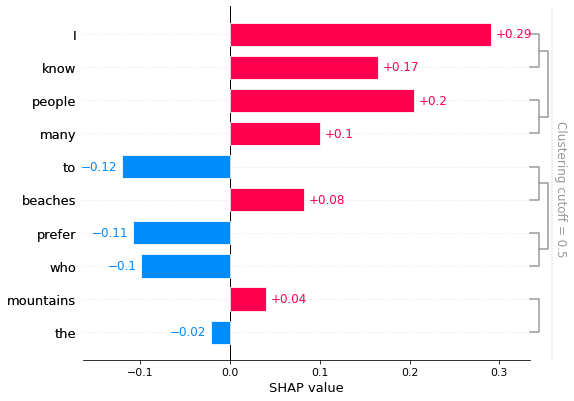

In [0]:
shap.plots.bar(shap_values2[0, :, "not"])

Common model interpretability methods for text classification are not as informative for language model predictions because the most recent input token usually is the most influential token to the subsequent predicted token. This is called recency bias and it's a difficult problem to tackle. While SHAP gave us an idea what input token may have contributed to the output token, it's not really all that useful. 

Let's take a look at the final example.

In [0]:
input_sentence3 = ["Can you stop the dog from"]
shap_values3 = explainer(input_sentence3)
shap.plots.text(shap_values3)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.


[0] 
 
 

 outputs 
 barking 
 ? 
 
 
 No 
 . 
 
 
 What 
 if 
 I 
 tell 
 you 
 that -3 -6 -9 -12 0 3 6 -14.3879 -14.3879 base value -1.80219 -1.80219 f barking (inputs) 4.987 dog 4.863 stop 1.63 from 0.52 Can 0.501 the 0.084 you <rect x="36.213282788667996%" y="40" height="20" width="20.386601674065382%" onmouseover="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_4').style.textDecoration = 'underline';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_4').style.opacity = 1;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_4').style.opacity = 1;" onmouseout="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_4').style.textDecoration = 'none';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_4').style.opacity = 0;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_4').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="16.332052206865377%" y="40" height="20" width="19.88123058180262%" onmouseover="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_2').style.textDecoration = 'underline';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_2').style.opacity = 1;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_2').style.opacity = 1;" onmouseout="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_2').style.textDecoration = 'none';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_2').style.opacity = 0;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_2').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="9.667983831415022%" y="40" height="20" width="6.664068375450356%" onmouseover="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_5').style.textDecoration = 'underline';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_5').style.opacity = 1;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_5').style.opacity = 1;" onmouseout="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_5').style.textDecoration = 'none';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_5').style.opacity = 0;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_5').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="7.540088530724257%" y="40" height="20" width="2.1278953006907644%" onmouseover="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_0').style.textDecoration = 'underline';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_0').style.opacity = 1;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_0').style.opacity = 1;" onmouseout="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_0').style.textDecoration = 'none';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_0').style.opacity = 0;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_0').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> <rect x="5.490285933895471%" y="40" height="20" width="2.049802596828786%" onmouseover="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_3').style.textDecoration = 'underline';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_3').style.opacity = 1;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_3').style.opacity = 1;" onmouseout="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_3').style.textDecoration = 'none';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_3').style.opacity = 0;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_3').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /><rect x="5.145444042066666%" y="40" height="20" width="0.3448418918288052%" onmouseover="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_1').style.textDecoration = 'underline';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_1').style.opacity = 1;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_1').style.opacity = 1;" onmouseout="document.getElementById('_tp_nofbkomcvogtdfubfamd_ind_1').style.textDecoration = 'none';document.getElementById('_fs_nofbkomcvogtdfubfamd_ind_1').style.opacity = 0;document.getElementById('_fb_nofbkomcvogtdfubfamd_ind_1').style.opacity = 0;" style="fill:rgb(0,0,0,0)" /> inputs 0.52 <div id='_tp_nofbkomcvogtdfubfamd_ind_0'
 sty

In the example above, we see that the predicted token is `barking`. But we don't know why the model doesn't output tokens like `crying`, `eating`, `biting`, etc. It would be a lot more interesting if we can know *why* the model outputs `barking` **instead of** `crying` and other viable word candidates. This `instead of` explanation is called `contrastive explanation` ([Yin and Neubig 2022](https://aclanthology.org/2022.emnlp-main.14.pdf)). 


Let the actual output token be `target_token` and the viable output token be `foil_token`. Intuitively, there are three methods to generate such contrastive explanations: 
1. Calculate how much an input token influences the probability of `target_token`, while decreasing the probability of `foil_token`
2. Calculate how much erasing an input token increases the probability of `foil_token` and reduces that of `target_token` 
3. Calculate the dot product between the input token embedding and the output token. 

<img src="https://files.training.databricks.com/images/constrastive_exp.png" width=300>

Courtesy of the author's, Kayo Yin's, [slides](https://kayoyin.github.io/assets/slides/melb22.pdf). Below, we are going to use Yin's [Python module](https://github.com/kayoyin/interpret-lm/tree/main) to generate contrastive explanation for us! The code is currently in a research state, rather than readily packaged on PyPI or production-ready, but it is still interesting to see current (and potential future) state of research directions.

We will walk through the results directly in the markdown. If you are interested in running this code, you can download `lm_saliency.py` from the [repo](https://github.com/kayoyin/interpret-lm/blob/main/lm_saliency.py) and import it into your `LLM 05 - LLMs and Society` folder. 

```
from transformers import GPT2Tokenizer, GPT2LMHeadModel

gpt2_tokenizer = GPT2Tokenizer.from_pretrained(
    "gpt2",
    cache_dir=DA.paths.datasets)
gpt2_model = GPT2LMHeadModel.from_pretrained(
    "gpt2",
    cache_dir=DA.paths.datasets)

input_tokens = gpt2_tokenizer(input_sentence3[0])["input_ids"]
attention_ids = gpt2_tokenizer(input_sentence3[0])["attention_mask"]
```

Recall that `input_sentence3[0]` is `Can you stop the dog from`.

We will use the erasure method to generate explanation. 

```
import lm_saliency
from lm_saliency import *

target = "barking" # target refers to the word we would like to generate explanation on
foil = "crying" # foil refers to any other possible word 
explanation = "erasure"
CORRECT_ID = gpt2_tokenizer(" " + target)["input_ids"][0]
FOIL_ID = gpt2_tokenizer(" " + foil)["input_ids"][0]

# Erasure
base_explanation = erasure_scores(gpt2_model, input_tokens, attention_ids, normalize=True)
contra_explanation = erasure_scores(gpt2_model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)

visualize(np.array(base_explanation), gpt2_tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target}?")
visualize(np.array(contra_explanation), gpt2_tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target} instead of {foil}?")
```

<img src="https://files.training.databricks.com/images/llm/lm_saliency.png" width=1000>

The score measures how much each token influences the model to attribute a higher probability to the target token. In this example above, `stop` makes the model more likely to predict `barking` whereas `the` doesn't influence whether the model predicts `barking` or `crying`.  


How we can use contrastive explanation to improve LLMs is still an ongoing research! It's not surprising that the research so far has shown that contrastive explanation can help us characterize how LLMs decide which output token to predict. It's an exciting space to watch for development!

-sandbox
&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>